### Importing modules

In [34]:
import hoomd
import hoomd.hpmc as hpmc
import coxeter
import ipywidgets as widgets
import gsd, gsd.hoomd
import plato.draw.vispy as draw
import numpy as np
import matplotlib.pyplot as pp

### Choosing parameters for our simulation

This includes choosing the two shapes we will be using, the ratio between the shapes, and the total number of shapes in the simulation box.

In [24]:
getShape = coxeter.families.RegularNGonFamily()

def make3D(vertex_list):
    to_add = np.transpose([np.zeros(len(vertex_list))])
    vertex_list = np.concatenate([vertex_list,to_add],axis=1)
    return vertex_list

#Choose shapes by the number of vertices that shape has
verticesA = make3D(getShape.make_vertices(3))
verticesB = make3D(getShape.make_vertices(5))

In [25]:
# Choose a fraction between 0 and 1
# which will represent the percent of shapes
# that are Shape 1
# shape_ratio = 0 means all the shapes will be Shape 2

shape_ratio = widgets.FloatSlider(
    min=0.00, 
    max=1.00, 
    step=0.01, 
    description='Shape ratio:', 
    value=0.50,
    readout_format='.2f')

display(shape_ratio)

FloatSlider(value=0.5, description='Shape ratio:', max=1.0, step=0.01)

In [11]:
# Setting number of particles along one side of our simulation box
# which is the square root of the total number of particles
num_particles_sqrt = 20

In [12]:
#setting colors

### Initializing the simulation

In [13]:
#making & visualizing the unit cell

In [47]:
hoomd.context.initialize("--mode=cpu");

system = hoomd.init.create_lattice(unitcell=hoomd.lattice.unitcell(N=2,
                                                                  a1=[3,0,0],
                                                                  a2=[0,6,0],
                                                                  a3=[0,0,1],
                                                                  dimensions=2,
                                                                  position=[[0,0,0],
                                                                            [0,3,0]],
                                                                  type_name=["A","B"]),
                                n=[num_particles_sqrt,int(1/2*num_particles_sqrt)])

snap = system.take_snapshot()

snap.particles.types = ["A","B"]

nParticles = len(snap.particles.typeid)

for p in range(int(shape_ratio.value * nParticles)):
    snap.particles.typeid[p]=0
for p in range(int(int(shape_ratio.value * nParticles)), nParticles ):
    snap.particles.typeid[p]=1
    
system.restore_snapshot(snap)

notice(2): Group "all" created containing 400 particles


In [48]:
#visualizing our initial frame with plato
primA = draw.Polygons(vertices = verticesA[:,:2])
primB = draw.Polygons(vertices = verticesB[:,:2])
box_prim = draw.Box(color=(0, 0, 0, 1), width=.2)
scene = draw.Scene([primA, box_prim], zoom=.5, clip_scale=5)
scene.add_primitive(primB)
scene.show()

box = [snap.box.Lx, snap.box.Ly, snap.box.Lz, snap.box.xy, snap.box.xz, snap.box.yz]
for (name, val) in zip(['Lx', 'Ly', 'Lz', 'xy', 'xz', 'yz'], box):
    setattr(box_prim, name, val)  

primA.positions = snap.particles.position[snap.particles.typeid == 0,:2]
primB.positions = snap.particles.position[snap.particles.typeid == 1,:2]

primA.orientations = snap.particles.orientation
primB.orientations = snap.particles.orientation

primA.diameters = np.full(len(snap.particles.position), 1)
primB.diameters = np.full(len(snap.particles.position), 1)

colorsA = np.ones((len(primA.positions), 4))
colorsA[:, :3] = np.float32(np.divide([255, 50, 150], 255)) #pink
primA.colors = colorsA

colorsB = np.ones((len(primB.positions), 4))
colorsB[:, :3] = np.float32(np.divide([0, 200, 100], 255)) #green
primB.colors = colorsB

scene.render()

VispyWidget(height=600, width=800)

### Running the simulation

In [49]:
total_steps = 1e6
max_pressure = 20

mc = hpmc.integrate.convex_polygon(seed=np.random.randint(1,1e6), d=0.5, a=0.5, move_ratio=0.5)
mc.shape_param.set('A', vertices=verticesA)
mc.shape_param.set('B', vertices=verticesB)

boxMC = hpmc.update.boxmc(mc, hoomd.variant.linear_interp(points=[[0,1],[total_steps,max_pressure]],zero=0), 
                          np.random.randint(1,1e6))

boxMC.volume(delta=1.0, weight=1.0)

particle_tuner = hpmc.util.tune(obj=mc, tunables=['d','a'], target=0.2)
box_tuner = hpmc.util.tune_npt(obj=boxMC, tunables=['dV'],  target=0.2)


all=hoomd.group.all()

In [50]:
#record data

#for visualizations
traj = hoomd.dump.gsd(filename='traj.gsd',period=int(total_steps/100),group=all,overwrite=True)
traj.dump_shape(mc)

#for plots

logger = hoomd.analyze.log(filename='log.txt',
    quantities=['hpmc_translate_acceptance',
                'hpmc_rotate_acceptance',
                'hpmc_boxmc_volume_acceptance',
                'hpmc_d',
                'lx',
                'hpmc_boxmc_betaP',
                'hpmc_overlap_count'
                ],
    period=int(total_steps/100),
    overwrite=True)

In [51]:
number_loops = 10
loop_steps = int(total_steps/number_loops)

for i in range(number_loops):
    hoomd.run(loop_steps)
    particle_tuner.update()
    box_tuner.update()

** starting run **
Time 00:00:12 | Step 11942 / 100000 | TPS 1194.12 | ETA 00:01:13
Time 00:00:22 | Step 22663 / 100000 | TPS 1072.01 | ETA 00:01:12
Time 00:00:32 | Step 32164 / 100000 | TPS 950.028 | ETA 00:01:11
Time 00:00:42 | Step 41587 / 100000 | TPS 942.209 | ETA 00:01:01
Time 00:00:52 | Step 51070 / 100000 | TPS 948.233 | ETA 00:00:51
Time 00:01:02 | Step 60450 / 100000 | TPS 937.939 | ETA 00:00:42
Time 00:01:12 | Step 69545 / 100000 | TPS 909.486 | ETA 00:00:33
Time 00:01:22 | Step 78811 / 100000 | TPS 926.584 | ETA 00:00:22
Time 00:01:32 | Step 88018 / 100000 | TPS 920.681 | ETA 00:00:13
Time 00:01:42 | Step 97354 / 100000 | TPS 933.574 | ETA 00:00:02
Time 00:01:45 | Step 100000 / 100000 | TPS 934.988 | ETA 00:00:00
Average TPS: 972.422
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.417081
notice(2): Average rotate acceptance:    0.684504
notice(2): Trial moves per second:        1.55586e+06
notice(2): Overlap checks per second:     3.09941e+07


Time 00:12:40 | Step 700000 / 700000 | TPS 918.821 | ETA 00:00:00
Average TPS: 884.625
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.134499
notice(2): Average rotate acceptance:    0.157977
notice(2): Trial moves per second:        1.41539e+06
notice(2): Overlap checks per second:     2.39927e+07
notice(2): Overlap checks per trial move: 16.9514
notice(2): Number of overlap errors:      0
notice(2): -- HPMC box change stats:
notice(2): Average volume acceptance: 0.12672
notice(2): Total box changes:        100000
** run complete **
** starting run **
Time 00:12:50 | Step 708960 / 800000 | TPS 895.988 | ETA 00:01:41
Time 00:13:00 | Step 717839 / 800000 | TPS 887.84 | ETA 00:01:32
Time 00:13:10 | Step 726751 / 800000 | TPS 891.195 | ETA 00:01:22
Time 00:13:20 | Step 735713 / 800000 | TPS 896.109 | ETA 00:01:11
Time 00:13:30 | Step 744683 / 800000 | TPS 896.898 | ETA 00:01:01
Time 00:13:40 | Step 753495 / 800000 | TPS 881.15 | ETA 00:00:52
Time 00:13:50 | 

In [ ]:
#graph volume over time -- Rachael
#graph packing fraction over time -- Rachael

### Visualizing your simulation

In [52]:
def getFrameCount(fname):
    #inputs: fname, the filename (ex: 'dump.gsd')
    #outputs: len(traj), number of frames in simulation
    with gsd.hoomd.open(fname, 'rb') as traj:
        return len(traj)

In [53]:
primA = draw.Polygons(vertices = verticesA[:,:2])
primB = draw.Polygons(vertices = verticesB[:,:2])
box_prim = draw.Box(color=(0, 0, 0, 1), width=.2)
scene = draw.Scene([primA, box_prim], zoom=.5, clip_scale=5)
scene.add_primitive(primB)
scene.show()

filename = 'traj.gsd'
frame_num = getFrameCount(filename)

@widgets.interact(frame_index=(0, frame_num-1, 1))
def plot(frame_index=0):
    with gsd.hoomd.open(filename, 'rb') as traj:
        frame = traj[frame_index]
        box = frame.configuration.box
        for (name, val) in zip(['Lx', 'Ly', 'Lz', 'xy', 'xz', 'yz'], box):
            setattr(box_prim, name, val)  
            
        primA.positions = frame.particles.position[frame.particles.typeid == 0,:2]
        primB.positions = frame.particles.position[frame.particles.typeid == 1,:2]
        
        primA.orientations = frame.particles.orientation
        primB.orientations = frame.particles.orientation
        
        primA.diameters = np.full(len(frame.particles.position), 1)
        primB.diameters = np.full(len(frame.particles.position), 1)
        
        colorsA = np.ones((len(primA.positions), 4))
        colorsA[:, :3] = np.float32(np.divide([255, 50, 150], 255)) #pink
        primA.colors = colorsA
        
        colorsB = np.ones((len(primB.positions), 4))
        colorsB[:, :3] = np.float32(np.divide([0, 200, 100], 255)) #green
        primB.colors = colorsB
    scene.render()

VispyWidget(height=600, width=800)

interactive(children=(IntSlider(value=0, description='frame_index', max=99), Output()), _dom_classes=('widget-…

In [54]:
#Plotting values

data = np.loadtxt('log.txt',skiprows=1)

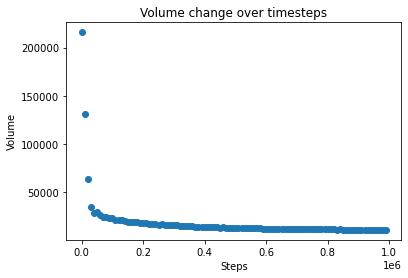

In [55]:
#Volume changes with time

time = data[:,0]
lx = data[:,5]
volume = lx ** 3

pp.scatter(time, volume);
pp.title('Volume change over timesteps');
pp.xlabel('Steps');
pp.ylabel('Volume');

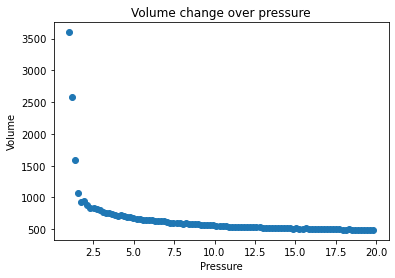

In [56]:
#Volume changes with pressure

pressure = data[:,6]
lx = data[:,5]
volume = lx ** 2

pp.scatter(pressure, volume);
pp.title('Volume change over pressure');
pp.xlabel('Pressure');
pp.ylabel('Volume');

(400.0, 1000.0)

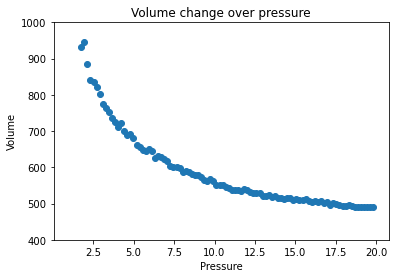

In [58]:
#Zoom in on the part below the initial compression

pp.scatter(pressure, volume);
pp.title('Volume change over pressure');
pp.xlabel('Pressure');
pp.ylabel('Volume');

pp.ylim(400,1000)